In [1]:
import tensorflow as tf

In [2]:
(train_img, train_lbl), (test_img, test_lbl)= tf.keras.datasets.cifar10.load_data()

In [3]:
def normalize(img):
    img = tf.cast(img, tf.float32) / 255
    return img

In [4]:
train_img = train_img / 255
test_img = test_img / 255
train_ds = tf.data.Dataset.from_tensor_slices((train_img, train_lbl))
test_ds = tf.data.Dataset.from_tensor_slices((test_img, test_lbl))

In [5]:
img_size = (32, 32, 3)
num_classes = 10

In [26]:
cluster_resolver = tf.distribute.cluster_resolver.TFConfigClusterResolver()

strategy = tf.distribute.MultiWorkerMirroredStrategy(cluster_resolver=cluster_resolver)

with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=img_size, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [59]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 13, 13, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,512 (181.69 KB)

 Trainable params: 15,450 (60.35 KB)

 Non-trainable params: 160 (640.00 B)

 Optimizer params: 30,902 (120.71 KB)

In [28]:
batch_size = 50

train_ds_ = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds_ = test_ds.batch(batch_size)

history1 = model.fit(
    train_ds_,
    epochs=20,
    validation_data=test_ds_,
    shuffle=True
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6179 - loss: 1.1589 - val_accuracy: 0.5715 - val_loss: 1.3112
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6559 - loss: 1.0607 - val_accuracy: 0.5841 - val_loss: 1.2985
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6785 - loss: 1.0040 - val_accuracy: 0.6407 - val_loss: 1.1027
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6927 - loss: 0.9661 - val_accuracy: 0.6280 - val_loss: 1.1534
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7054 - loss: 0.9370 - val_accuracy: 0.6332 - val_loss: 1.1290
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7155 - loss: 0.9143 - val_accuracy: 0.6453 - val_loss: 1.1110
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7240 - loss: 0.8962 - val_accuracy: 0.6368 - val_loss: 1.1722
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7284 -

In [37]:
batch_size = 40

train_ds_ = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds_ = test_ds.batch(batch_size)

history2 = model.fit(
    train_ds_,
    epochs=5,
    validation_data=test_ds_,
    shuffle=True
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.7882 - loss: 0.7565 - val_accuracy: 0.6850 - val_loss: 1.0584
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7807 - loss: 0.7665 - val_accuracy: 0.6952 - val_loss: 1.0341
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7768 - loss: 0.7736 - val_accuracy: 0.6842 - val_loss: 1.0754
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7776 - loss: 0.7742 - val_accuracy: 0.6925 - val_loss: 1.0436
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7769 - loss: 0.7742 - val_accuracy: 0.6922 - val_loss: 1.0570


In [40]:
batch_size = 25

train_ds_ = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds_ = test_ds.batch(batch_size)

history3 = model.fit(
    train_ds_,
    epochs=7,
    validation_data=test_ds_,
    shuffle=True
)

Epoch 1/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7655 - loss: 0.8105 - val_accuracy: 0.6973 - val_loss: 1.0452
Epoch 2/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7614 - loss: 0.8209 - val_accuracy: 0.7006 - val_loss: 1.0282
Epoch 3/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7595 - loss: 0.8247 - val_accuracy: 0.6943 - val_loss: 1.0407
Epoch 4/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7600 - loss: 0.8238 - val_accuracy: 0.7107 - val_loss: 1.0163
Epoch 5/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7604 - loss: 0.8230 - val_accuracy: 0.6954 - val_loss: 1.0598
Epoch 6/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.7621 - loss: 0.8237 - val_accuracy: 0.7042 - val_loss: 1.0150
Epoch 7/7
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.7615 - loss: 0.8236 - val_accuracy: 0.7018 - val_loss: 1.0410


In [41]:
import matplotlib.pyplot as plt

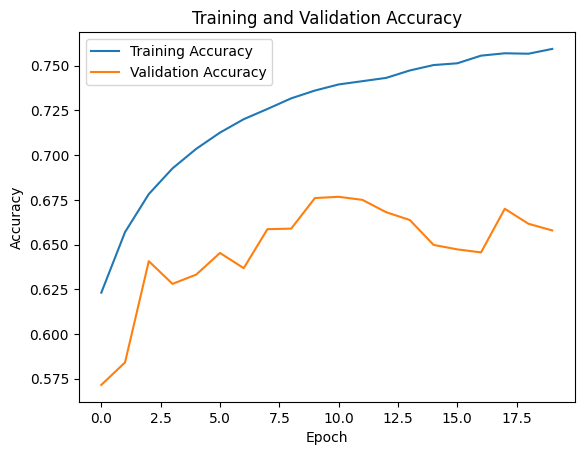

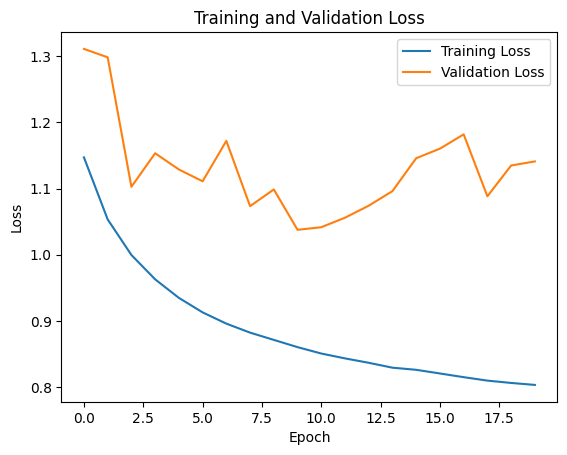

In [42]:
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy'] 

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

train_accuracy = history1.history['loss']
val_accuracy = history1.history['val_loss'] 

plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

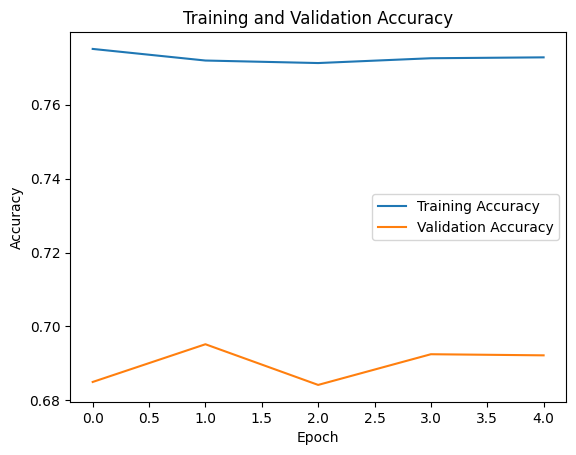

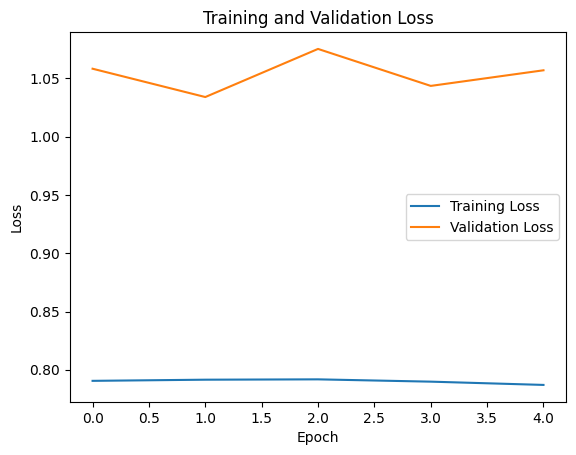

In [43]:
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy'] 

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

train_accuracy = history2.history['loss']
val_accuracy = history2.history['val_loss'] 

plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

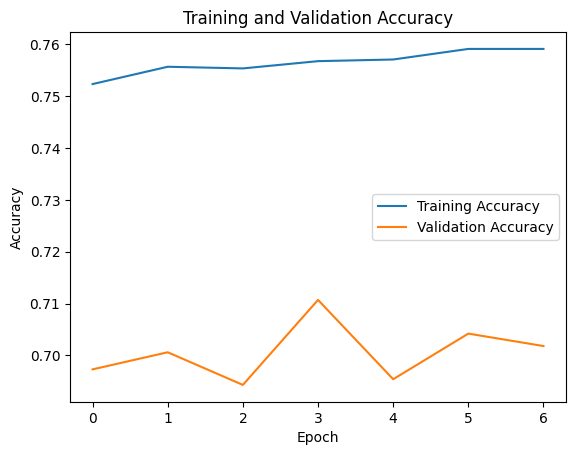

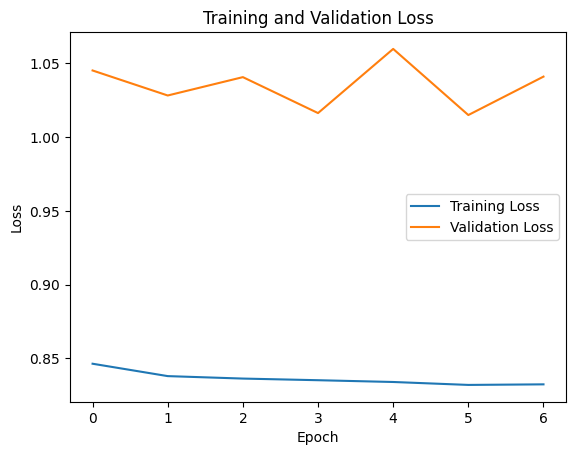

In [46]:
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy'] 

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

train_accuracy = history3.history['loss']
val_accuracy = history3.history['val_loss'] 

plt.plot(train_accuracy, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


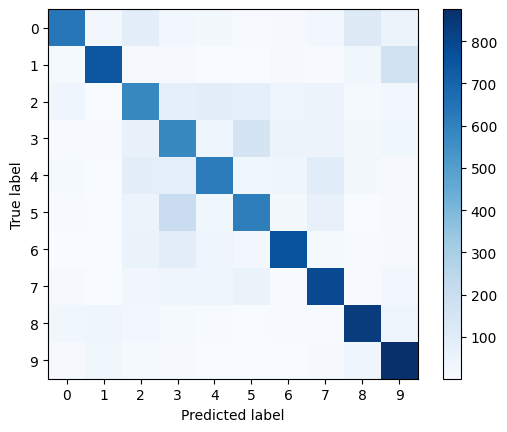

In [58]:
for test_img, test_label in test_ds.batch(10000):
    y_pred = model.predict(test_img)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    break

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(test_label, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=range(10))
disp.plot(include_values=False, cmap='Blues')
plt.show()

In [51]:
model.save('model.h5')